In [51]:
import pandas as pd
import numpy as np
from typing import Optional, Literal


import pandas as pd
import numpy as np
import re


import pandas as pd
import numpy as np
import re


def parse_date_raw_column(
    df: pd.DataFrame,
    date_col: str = "date_raw",
    *,
    default_year: int = 2024,
    out_col: str = "date",
) -> pd.DataFrame:
    """
    Parse 'date_raw' values that come in two formats:

    1) 'Nov. 01'  (or 'Nov 01')
       -> interpreted as '%b %d' with an injected `default_year`.

    2) '24-10-30'
       -> interpreted as '%y-%m-%d' (YY-MM-DD).

    Any other formats fall back to pandas.to_datetime(..., errors='coerce')
    and become NaT if still unparseable.
    """

    def _parse_one(s: str) -> pd.Timestamp:
        s = str(s).strip()
        if not s or s.lower() in {"nan", "none"}:
            return pd.NaT

        # 1) Month-name style: 'Nov. 01' or 'Nov 01'
        #    Allow optional dot after month, then space, then 1–2 digits.
        if re.match(r"^[A-Za-z]{3}\.?\s+\d{1,2}$", s):
            s_clean = s.replace(".", "")  # 'Nov. 01' -> 'Nov 01'
            return pd.to_datetime(
                f"{s_clean} {default_year}",  # e.g. 'Nov 01 2024'
                format="%b %d %Y",
                errors="coerce",
            )

        # 2) Short numeric with hyphens: '24-10-30' -> %y-%m-%d
        if re.match(r"^\d{2}-\d{2}-\d{2}$", s):
            return pd.to_datetime(s, format="%y-%m-%d", errors="coerce")

        # 3) Fallback: let pandas try its best (covers '2024-10-30', etc.)
        return pd.to_datetime(s, errors="coerce")

    df = df.copy()
    df[out_col] = df[date_col].apply(_parse_one)

    # Optional: warn about any rows that couldn't be parsed
    bad_vals = df.loc[df[out_col].isna(), date_col].unique()
    if len(bad_vals) > 0:
        print("Warning: could not parse some date_raw values, e.g.:")
        print(bad_vals[:10])

    return df



def build_daily_sentiment(
    df_sent: pd.DataFrame,
    *,
    date_col: str = "date",
    score_col: str = "sentiment_score",
    agg: Literal["mean", "median"] = "mean",
) -> pd.DataFrame:
    """
    Aggregate intraday / multi-headline sentiment into one daily score.

    Parameters
    ----------
    df_sent : DataFrame
        Must contain date_col (datetime) and score_col (float in [-1,1]).
    agg : {'mean', 'median'}
        How to aggregate multiple headlines per day.

    Returns
    -------
    DataFrame indexed by date with column 'daily_score'.
    """
    df = df_sent.copy()
    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        raise ValueError(f"{date_col} must be datetime, got {df[date_col].dtype}")

    if agg == "mean":
        daily = df.groupby(df[date_col].dt.date)[score_col].mean()
    elif agg == "median":
        daily = df.groupby(df[date_col].dt.date)[score_col].median()
    else:
        raise ValueError("agg must be 'mean' or 'median'")

    daily = daily.to_frame(name="daily_score")
    daily.index = pd.to_datetime(daily.index)
    return daily.sort_index()


In [52]:
import yfinance as yf


def download_price_data(
    ticker: str = "AAPL",
    start: Optional[str] = None,
    end: Optional[str] = None,
) -> pd.DataFrame:
    """
    Download OHLCV daily data from Yahoo Finance using yfinance.

    Parameters
    ----------
    ticker : str
        e.g. 'AAPL'
    start, end : str or None
        e.g. '2024-01-01'. If None, yfinance uses its defaults.

    Returns
    -------
    DataFrame with Date index and columns including 'Adj Close'.
    """
    df_price = yf.download(ticker, start=start, end=end, auto_adjust=False)
    # Ensure Date index is tz-naive and sorted
    df_price = df_price.sort_index()
    return df_price


In [53]:
from typing import Tuple


def build_trading_signal_from_sentiment(
    daily_sent: pd.DataFrame,
    *,
    score_col: str = "daily_score",
    long_threshold: float = 0.2,
    short_threshold: float = -0.2,
) -> pd.DataFrame:
    """
    Convert daily sentiment score into a position in [-1, 0, 1].

    long_threshold : if score >= this, go long
    short_threshold: if score <= this, go short

    Returns
    -------
    DataFrame indexed by date with column 'signal' in {-1,0,1}.
    """
    s = daily_sent[score_col].copy()

    signal = np.where(s >= long_threshold, 1.0,
              np.where(s <= short_threshold, -1.0, 0.0))

    out = daily_sent.copy()
    out["signal"] = signal
    return out[["signal", score_col]]


In [54]:
def backtest_sentiment_strategy(
    price_df: pd.DataFrame,
    signal_df: pd.DataFrame,
    *,
    cost_bps: float = 1.0,
    price_col: str = "Adj Close",
) -> pd.DataFrame:
    """
    Simple daily backtest:
      - Use sentiment-based signal as position ∈ {-1,0,1}
      - Apply transaction costs on position changes
      - Compare to buy&hold (long 1, no leverage)

    Parameters
    ----------
    price_df : DataFrame
        Must have column price_col and a DatetimeIndex with trading days.
    signal_df : DataFrame
        Must be indexed by date with a 'signal' column.
    cost_bps : float
        Transaction cost in basis points (1 bp = 0.0001) applied when signal changes.
    price_col : str
        Column to compute returns from.

    Returns
    -------
    DataFrame indexed by date with columns:
        'ret_aapl'        : raw AAPL daily returns
        'signal'          : position in [-1,0,1]
        'strategy_ret'    : daily strategy return
        'buyhold_ret'     : daily buy&hold return (same as ret_aapl)
        'strategy_equity' : cumulative equity curve (start at 1.0)
        'buyhold_equity'  : cumulative equity curve for buy&hold
    """
    if price_col not in price_df.columns:
        raise ValueError(f"{price_col} not found in price_df.columns")

    df = price_df[[price_col]].copy()
    df = df.sort_index()

    # raw daily returns
    df["ret_aapl"] = df[price_col].pct_change().fillna(0.0)

    # align signal to trading days; forward-fill between news days
    sig = signal_df[["signal"]].copy()
    sig = sig.sort_index()
    # reindex to trading calendar
    sig = sig.reindex(df.index).ffill().fillna(0.0)

    df["signal"] = sig["signal"]

    # use yesterday's signal to trade today's return (avoid look-ahead)
    df["position"] = df["signal"].shift(1).fillna(0.0)

    # transaction cost when position changes
    # cost per change: cost_bps * |Δposition|
    # daily cost = cost_bps/10000 * |position_t - position_{t-1}|
    delta_pos = df["position"].diff().fillna(df["position"])
    trade_cost = (cost_bps / 10000.0) * delta_pos.abs()

    df["strategy_ret"] = df["position"] * df["ret_aapl"] - trade_cost
    df["buyhold_ret"] = df["ret_aapl"]

    df["strategy_equity"] = (1.0 + df["strategy_ret"]).cumprod()
    df["buyhold_equity"] = (1.0 + df["buyhold_ret"]).cumprod()

    return df


In [55]:
import matplotlib.pyplot as plt


def plot_equity_curves(bt_df: pd.DataFrame) -> None:
    """
    Plot strategy vs buy&hold equity curves.
    """
    plt.figure(figsize=(10, 5))
    bt_df[["strategy_equity", "buyhold_equity"]].plot(ax=plt.gca())
    plt.ylabel("Equity (normalized)")
    plt.title("AAPL – Sentiment strategy vs Buy & Hold")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [56]:
import pandas as pd

df_scored_rag = pd.read_csv("data/AAPL_sentiment_rag.csv")

df_scored_rag = parse_date_raw_column(
    df_scored_rag,
    date_col="date_raw",
    default_year=2025,  # or 2023/2025 if that matches your data better
    out_col="date",
)


In [57]:
df_scored_rag.head()    

,title,date_raw,source_code,body,sentiment,sentiment_score,sentiment_confidence,sentiment_rationale,sentiment_raw,date
0,Citigroup Adjusts Price Target on Apple to $33...,Dec. 09,MT,Citigroup Adjusts Price Target on Apple to $33...,bullish,0.85,0.90,The headline explicitly states a price target ...,"```json\n{\n ""sentiment"": ""bullish"",\n ""scor...",2025-12-09
1,Apple AI Strategy Finally Taking Shape Amid Ke...,Dec. 08,MT,Apple AI Strategy Finally Taking Shape Amid Ke...,bullish,0.85,0.95,"The mention of a 'new era' of growth, a key hi...","```json\n{\n ""sentiment"": ""bullish"",\n ""scor...",2025-12-08
2,Wedbush Ups PT on Apple to $350 From $320 on '...,Dec. 08,MT,Wedbush Ups PT on Apple to $350 From $320 on '...,bullish,0.85,0.95,The headline highlights strong iPhone sales an...,"```json\n{\n ""sentiment"": ""bullish"",\n ""scor...",2025-12-08
3,MoffettNathanson Adjusts Price Target on Apple...,Dec. 03,MT,MoffettNathanson Adjusts Price Target on Apple...,bullish,0.75,0.90,The headline indicates a revised price target ...,"```json\n{\n ""sentiment"": ""bullish"",\n ""scor...",2025-12-03
4,Loop Capital Adjusts Price Target on Apple to ...,Dec. 02,MT,Loop Capital Adjusts Price Target on Apple to ...,bullish,0.85,0.90,The headline indicates a positive adjustment t...,"```json\n{\n ""sentiment"": ""bullish"",\n ""scor...",2025-12-02


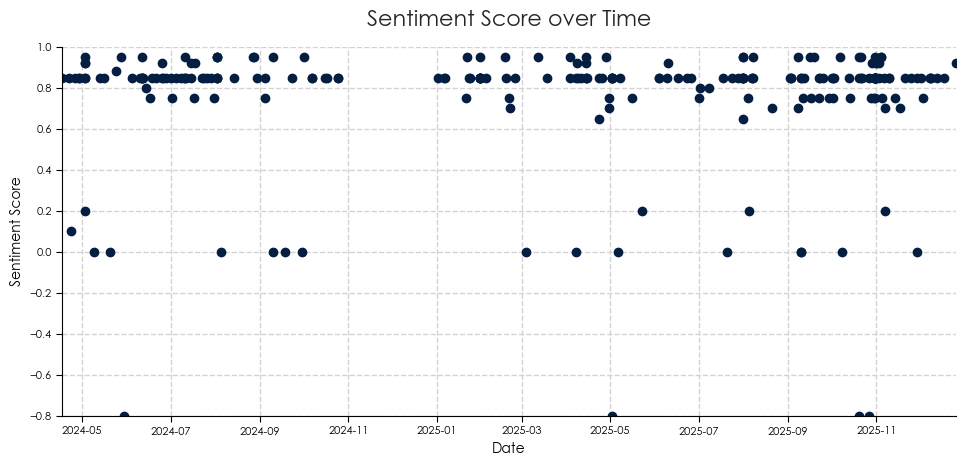

In [58]:
# plot sentiment over time
import matplotlib.pyplot as plt
from scripts import actiestilo
actiestilo.set_style()
plt.figure(figsize=(10, 5))
# remove the lines
plt.plot(df_scored_rag['date'], df_scored_rag['sentiment_score'], marker='o', linestyle='None')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score over Time')
plt.grid(True)
plt.tight_layout()

In [59]:
daily_sent = build_daily_sentiment(
    df_scored_rag,
    date_col="date",
    score_col="sentiment_score",
    agg="mean",
)

last_date = df_scored_rag['date'].max()
first_date = df_scored_rag['date'].min()
signal_df = build_trading_signal_from_sentiment(daily_sent)

price_df = download_price_data("AAPL", start=first_date.strftime("%Y-%m-%d"), end=last_date.strftime("%Y-%m-%d"))

bt_df = backtest_sentiment_strategy(price_df, signal_df)

[*********************100%***********************]  1 of 1 completed


In [68]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D


def plot_equity_colored_by_position(
    bt_df,
    *,
    equity_col: str = "strategy_equity",
    position_col: str = "position",
    buyhold_col: str = "buyhold_equity",
    baseline: float = 1.0,
):
    """
    Plot the strategy equity curve, color-coded by position, with a
    color-matched backfill under the curve:

        Long  (position > 0) -> green
        Short (position < 0) -> red
        Flat  (position == 0 or NaN) -> gray

    Also plots the buy & hold equity as a dashed line.

    Parameters
    ----------
    bt_df : DataFrame
        Output of backtest_sentiment_strategy (must contain equity_col,
        position_col, buyhold_col).
    baseline : float
        Baseline for the fill (default 1.0, i.e. initial equity level).
    """

    df = bt_df.copy().sort_index()

    if equity_col not in df.columns:
        raise ValueError(f"'{equity_col}' not found in bt_df.")
    if position_col not in df.columns:
        raise ValueError(f"'{position_col}' not found in bt_df.")
    if buyhold_col not in df.columns:
        raise ValueError(f"'{buyhold_col}' not found in bt_df.")

    dates = df.index.to_numpy()
    equity = df[equity_col].to_numpy()
    pos = df[position_col].fillna(0.0).to_numpy()

    # Color mapping
    def pos_to_color(p: float) -> str:
        if p > 0:
            return "green"   # long
        elif p < 0:
            return "red"     # short
        else:
            return "gray"    # flat

    fig, ax = plt.subplots(figsize=(12, 6))

    # Draw colored line + fill segments
    for i in range(1, len(df)):
        c = pos_to_color(pos[i])
        x_seg = dates[i-1:i+1]
        y_seg = equity[i-1:i+1]

        # Line segment
        ax.plot(x_seg, y_seg, color=c, linewidth=1.5)

        # Backfill segment (to baseline)
        ax.fill_between(
            x_seg,
            y_seg,
            baseline,
            color=c,
            alpha=0.18,
            linewidth=0,
        )

    # Overlay buy & hold equity as reference
    ax.plot(
        dates,
        df[buyhold_col].to_numpy(),
        color="black",
        alpha=0.3,
        label="Buy & hold equity",
    )

    ax.set_ylabel("Equity (normalized)")
    ax.set_title("AAPL – Sentiment strategy equity")
    ax.grid(True)

    # Custom legend for the colors
    legend_lines = [
        Line2D([0], [0], color="green", lw=1),
        Line2D([0], [0], color="red", lw=1),
        Line2D([0], [0], color="gray", lw=1),
        Line2D([0], [0], color="black", lw=1),
    ]
    legend_labels = ["Long", "Short", "Flat", "Buy & hold"]

    ax.legend(legend_lines, legend_labels, loc="upper left")

    fig.tight_layout()
    plt.show()


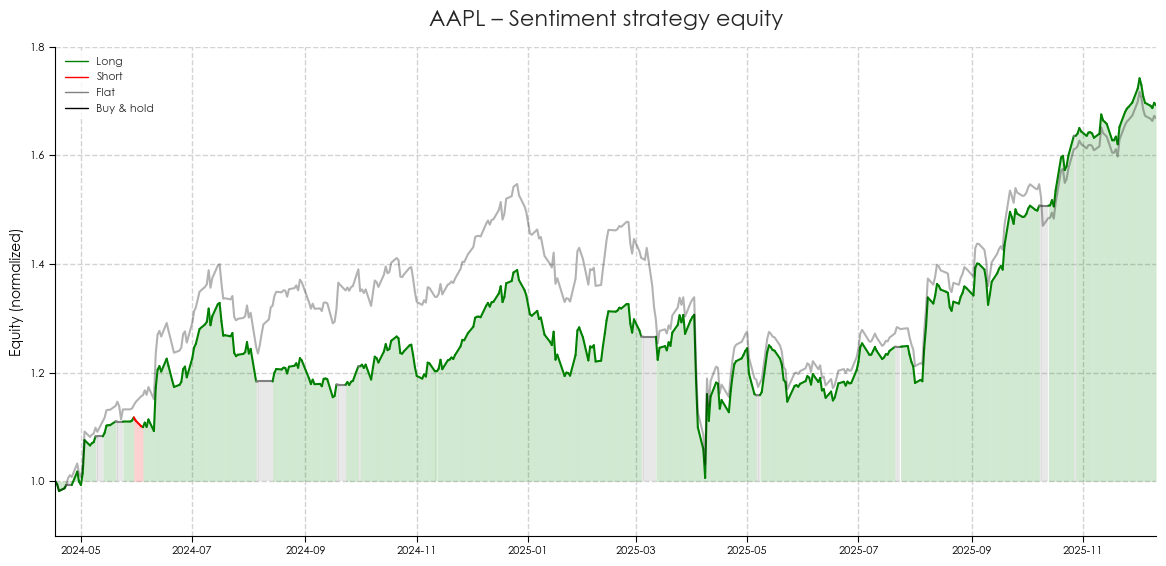

In [69]:
bt_df = backtest_sentiment_strategy(price_df, signal_df)
plot_equity_colored_by_position(bt_df)
